In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

import sys
sys.path.append('./functions')

from box_io import load_beeframe_meta_from_box
from comb_loading import get_organized_colony_names
from comb_loading import load_colony_comb    
from comb_loading import create_colonies_summary
from mask_processing import get_distance_to_class
from mask_processing import get_interior_mask, dilate_class

In [29]:
save = True

save_folder = "/home/golden/Dropbox/bee-comb/plots"
os.makedirs(save_folder, exist_ok=True)

In [30]:
comb_class = 2
wood_class = 1

load_meta_from_file = True
if load_meta_from_file:
    meta_file = "/home/golden/Dropbox/bee-comb/img_to_text_df_TOEDIT.csv"
    beeframe_meta = pd.read_csv(meta_file)

### Load all colonies with frame position info

In [31]:
colony_names = get_organized_colony_names(beeframe_meta)

colony_type_SH = "SH"
colony_type_DD = "DD"
max_week = 6

masks_folder_root = "/home/golden/kenya_drones/comb-detection/nest_photos"

colonies = []

for colony_name in colony_names:
    
    masks_folder_name = "ab_aligned_masks"
    colony = load_colony_comb(beeframe_meta, colony_name, 
                              masks_folder_root, masks_folder_name,
                              combine_ab=True, mirror_b=False
                             )
    if colony is None:
        print(f"skipping colony {colony_name}")
        continue
    # Sometimes there is a thin layer of false wood on comb edge
    # try to clean this up
    for day_ind, day in enumerate(colony):
        for frame_ind, frame in enumerate(day):
            colony[day_ind, frame_ind] = dilate_class(frame, comb_class, 4)
    if len(colony) > max_week:
        colony = colony[:max_week]
    print(f"loaded colony {colony_name} ({len(colony)} weeks sorted.)")
    colonies.append({"colony": colony, "type": colony_name[:2], "name": colony_name})

loaded colony DD1 (6 weeks sorted.)
loaded colony DD2 (6 weeks sorted.)
loaded colony DD4 (6 weeks sorted.)
loaded colony DD5 (6 weeks sorted.)
No valid info for frame 1, DD6, 20210728.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony DD6 (6 weeks sorted.)
loaded colony DD7 (6 weeks sorted.)
Warning multiple images for SH1 20210517  position 3 side a. Taking first one.
loaded colony SH1 (6 weeks sorted.)
loaded colony SH2 (6 weeks sorted.)
loaded colony SH3 (6 weeks sorted.)
loaded colony SH4 (6 weeks sorted.)
No valid info for frame 1, SH5, 20210412.
returning None
Colony is missing frame info. Returning day until this point.
skipping colony SH5
loaded colony SH6 (6 weeks sorted.)
loaded colony SH7 (6 weeks sorted.)


In [32]:
data_folder = "/home/golden/colony3d/data/comb_growth"
num_points = 50000
dataset_name = f"prob_growth_within_frame_wood_dist_comb_dist_{num_points}_points.csv"
dataset_file = os.path.join(data_folder, dataset_name)
load_dataset = True

In [33]:
if load_dataset:
    growth_df = pd.read_csv(dataset_file)

else:
    # build dataset
    feature_distances = []
    comb_presence = []
    colony_types = []

    growth_data = []

    interior_mask = get_interior_mask(colony[0,0])

    for _ in range(num_points):
        # Choose colony
        colony_ind = np.random.randint(len(colonies))
        colony_dict = colonies[colony_ind]
        colony = colony_dict["colony"]
        colony_type = colony_dict["type"]
        colony_name = colony_dict["name"]
        # Choose week
        # -1 so we don't choose the last frame where we don't know about future growth
        week = np.random.randint(colony.shape[0]-1)
        # Choose frame
        frame_num = np.random.randint(colony[week].shape[0])
        # Choose point in empty space within frame
        mask0 = colony[week, frame_num]
        empty_inds = np.argwhere((mask0==0)&(interior_mask))
        rand_ind = np.random.randint(empty_inds.shape[0])
        point = empty_inds[rand_ind]
        # Distance from point to existing comb and wood
        comb_distance, _ = get_distance_to_class(point, mask0, class_id=comb_class)
        if not comb_distance:
            # no comb present yet in this frame so ignore for this initial analysis
            continue
        wood_distance, _ = get_distance_to_class(point, mask0, class_id=wood_class)

        # Is there comb next week
        mask1 = colony[week+1, frame_num]
        if mask1[point[0], point[1]] == comb_class:
            comb_growth = 1
        else:
            comb_growth = 0

        point_data = {"colony": colony_name, "type": colony_type, "week": week,
                      "frame_position": frame_num, "growth": comb_growth, 
                      "wood_distance": wood_distance, "comb_distance": comb_distance
                     }
        growth_data.append(point_data)

    growth_df = pd.DataFrame(growth_data)

### Dataset basics

In [35]:
print(len(growth_df))
for exp_type in ["DD", "SH"]:
    exp_growth = growth_df.loc[growth_df['type']==exp_type]
    print(f"{len(exp_growth)} {exp_type} points.")
    print(f"{np.mean(exp_growth['growth']):.3f} overal growth probability for {exp_type}")
    exp_growth = growth_df.loc[(growth_df['type']==exp_type)
                              & (growth_df['colony']!="SH1")]
    print(f"excluding SH1 {len(exp_growth)} {exp_type} points.")
    print(f"excluding SH1 {np.mean(exp_growth['growth']):.3f} overal growth probability for {exp_type}")

40483
19469 DD points.
0.337 overal growth probability for DD
excluding SH1 19469 DD points.
excluding SH1 0.337 overal growth probability for DD
21014 SH points.
0.234 overal growth probability for SH
excluding SH1 19017 SH points.
excluding SH1 0.257 overal growth probability for SH


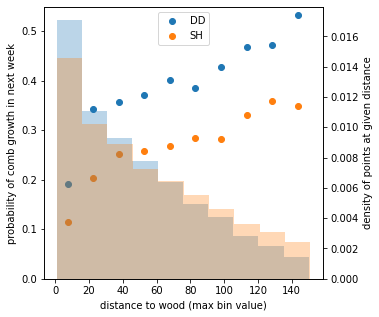

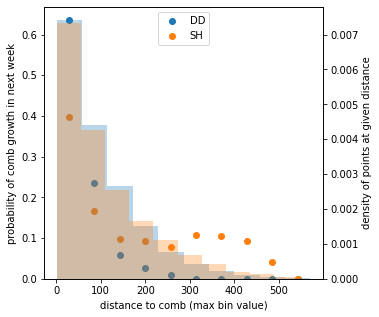

In [40]:
fig, ax0 = plt.subplots(1,1, figsize=(5,5))
ax1 = ax0.twinx()
max_wood_distance = growth_df['wood_distance'].max()
for exp_type in ["DD", "SH"]:
    exp_growth = growth_df.loc[growth_df['type']==exp_type]
    ret = binned_statistic(exp_growth['wood_distance'], 
                           exp_growth['growth'], statistic='mean', 
                           bins=10, range=(0, max_wood_distance))
    bin_edges = []
    for i, _ in enumerate(ret.bin_edges[:-1]): 
        bin_edges.append(np.mean([ret.bin_edges[i], ret.bin_edges[i+1]]))
    ax0.scatter(bin_edges, ret.statistic, label=exp_type)
    ax0.set_ylim([0, None])
    ax1.hist(exp_growth['wood_distance'], alpha=.3, density=True)
ax0.legend(loc='upper center')  
ax0.set_xlabel("distance to wood (max bin value)")
ax0.set_ylabel("probability of comb growth in next week")
ax1.set_ylabel("density of points at given distance")
if save:
    filename = f"prob_growth_distance_to_wood_by_condition.png"
    fig.savefig(os.path.join(save_folder, filename),
               dpi=300, bbox_inches='tight')
    
fig, ax0 = plt.subplots(1,1, figsize=(5,5))
ax1 = ax0.twinx()
max_comb_distance = growth_df['comb_distance'].max()
for exp_type in ["DD", "SH"]:
    exp_growth = growth_df.loc[growth_df['type']==exp_type]
    ret = binned_statistic(exp_growth['comb_distance'], 
                           exp_growth['growth'], statistic='mean', 
                           bins=10, range=(0, max_comb_distance))
    bin_edges = []
    for i, _ in enumerate(ret.bin_edges[:-1]): 
        bin_edges.append(np.mean([ret.bin_edges[i], ret.bin_edges[i+1]]))
    ax0.scatter(bin_edges, ret.statistic, label=exp_type)
    ax0.set_ylim([0, None])
    ax1.hist(exp_growth['comb_distance'], alpha=.3, density=True)
ax0.set_xlabel("distance to comb (max bin value)")
ax0.set_ylabel("probability of comb growth in next week")
ax1.set_ylabel("density of points at given distance")
ax0.legend(loc="upper center")

if save:
    filename = f"prob_growth_distance_to_comb_by_condition.png"
    fig.savefig(os.path.join(save_folder, filename),
               dpi=300, bbox_inches='tight')

### Exclude SH1

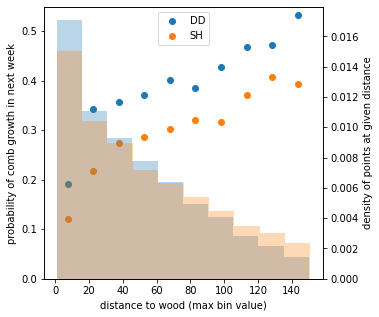

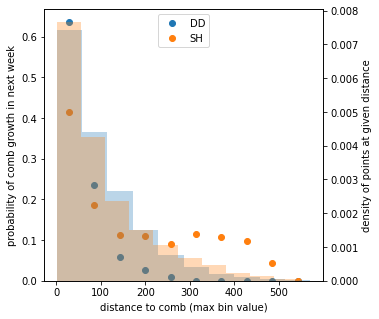

In [41]:
fig, ax0 = plt.subplots(1,1, figsize=(5,5))
ax1 = ax0.twinx()
max_wood_distance = growth_df['wood_distance'].max()
for exp_type in ["DD", "SH"]:
    exp_growth = growth_df.loc[(growth_df['type']==exp_type)
                               &(growth_df['colony']!="SH1")
                              ]
    ret = binned_statistic(exp_growth['wood_distance'], 
                           exp_growth['growth'], statistic='mean', 
                           bins=10, range=(0, max_wood_distance))
    bin_edges = []
    for i, _ in enumerate(ret.bin_edges[:-1]): 
        bin_edges.append(np.mean([ret.bin_edges[i], ret.bin_edges[i+1]]))
    ax0.scatter(bin_edges, ret.statistic, label=exp_type)
    ax0.set_ylim([0, None])
    ax1.hist(exp_growth['wood_distance'], alpha=.3, density=True)
ax0.legend(loc='upper center')  
ax0.set_xlabel("distance to wood (max bin value)")
ax0.set_ylabel("probability of comb growth in next week")
ax1.set_ylabel("density of points at given distance")
if save:
    filename = f"prob_growth_distance_to_wood_by_condition_excluding_SH1.png"
    fig.savefig(os.path.join(save_folder, filename),
               dpi=300, bbox_inches='tight')
    
fig, ax0 = plt.subplots(1,1, figsize=(5,5))
ax1 = ax0.twinx()
max_comb_distance = growth_df['comb_distance'].max()
for exp_type in ["DD", "SH"]:
    exp_growth = growth_df.loc[(growth_df['type']==exp_type)
                              &(growth_df['colony']!="SH1")
                              ]
    ret = binned_statistic(exp_growth['comb_distance'], 
                           exp_growth['growth'], statistic='mean', 
                           bins=10, range=(0, max_comb_distance))
    bin_edges = []
    for i, _ in enumerate(ret.bin_edges[:-1]): 
        bin_edges.append(np.mean([ret.bin_edges[i], ret.bin_edges[i+1]]))
    ax0.scatter(bin_edges, ret.statistic, label=exp_type)
    ax0.set_ylim([0, None])
    ax1.hist(exp_growth['comb_distance'], alpha=.3, density=True)
ax0.set_xlabel("distance to comb (max bin value)")
ax0.set_ylabel("probability of comb growth in next week")
ax1.set_ylabel("density of points at given distance")
ax0.legend(loc="upper center")
if save:
    filename = f"prob_growth_distance_to_comb_by_condition_excluding_SH1.png"
    fig.savefig(os.path.join(save_folder, filename),
               dpi=300, bbox_inches='tight')

### Comb vs wood distances
### (using all data again)

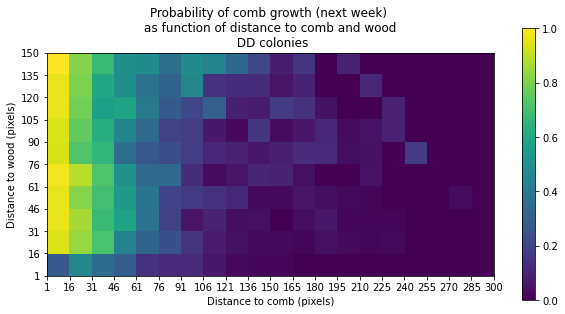

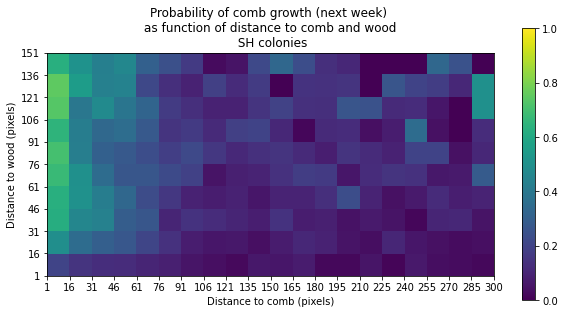

In [50]:


bins = 10
max_comb_distance = 300

for exp_type in ["DD", "SH"]:
    comb_feature = growth_df.loc[((growth_df['type']==exp_type)
                                  &(growth_df['comb_distance']<max_comb_distance)
                                 ), 
                                 "comb_distance"
                                ]
    wood_feature = growth_df.loc[((growth_df['type']==exp_type)
                                  &(growth_df['comb_distance']<max_comb_distance)
                                 ), 
                                 "wood_distance"
                                ]
    built = growth_df.loc[((growth_df['type']==exp_type)
                                  &(growth_df['comb_distance']<max_comb_distance)
                                 ), 
                          "growth"
                         ]

    ret = binned_statistic_2d(comb_feature, wood_feature, 
                              built, statistic='mean', bins=(bins*2, bins)
                             )
    
    plt.figure(figsize=(10, 5))
    plt.imshow(ret.statistic.T, origin='lower', vmin=0, vmax=1.0)
    # plt.gca().invert_yaxis()
    plt.colorbar()
    plt.gca().set_xticks(np.arange(-.5, bins*2, 1))
    plt.gca().set_xticklabels([f"{v:.0f}" for v in ret.x_edge])
    plt.xlabel("Distance to comb (pixels)")
    plt.gca().set_yticks(np.arange(-.5, bins, 1))
    plt.gca().set_yticklabels([f"{v:.0f}" for v in ret.y_edge])
    plt.ylabel("Distance to wood (pixels)")
    plt.title(f"Probability of comb growth (next week) \n as function of distance to comb and wood \n {exp_type} colonies")
    name = f"prob_comb_growth_func_wood_comb_{num_points}_SH_colonies"
    if save:
        filename = f"prob_comb_growth_func_wood_comb_{num_points}_{exp_type}_colonies.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

### Excluding SH1

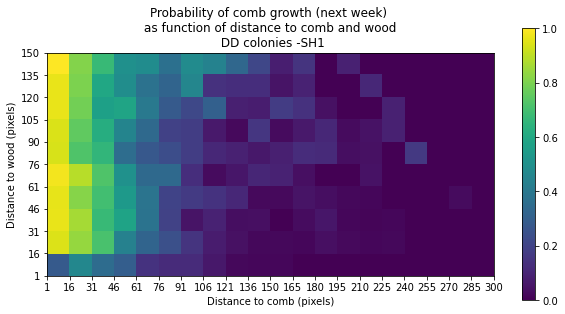

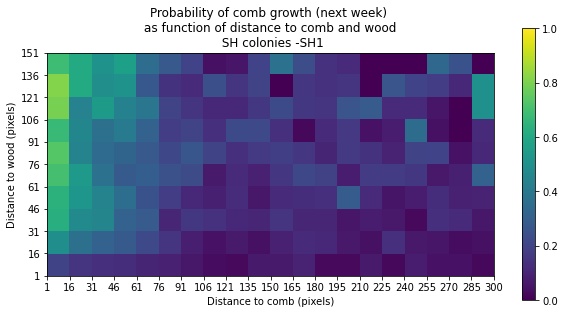

In [46]:
bins = 10
max_comb_distance = 300

for exp_type in ["DD", "SH"]:
    comb_feature = growth_df.loc[((growth_df['type']==exp_type)
                                  &(growth_df['comb_distance']<max_comb_distance)
                                  &(growth_df['colony']!="SH1")
                                 ), 
                                 "comb_distance"
                                ]
    wood_feature = growth_df.loc[((growth_df['type']==exp_type)
                                  &(growth_df['comb_distance']<max_comb_distance)
                                  &(growth_df['colony']!="SH1")
                                 ), 
                                 "wood_distance"
                                ]
    built = growth_df.loc[((growth_df['type']==exp_type)
                           &(growth_df['comb_distance']<max_comb_distance)
                           &(growth_df['colony']!="SH1")
                          ), 
                          "growth"
                         ]

    ret = binned_statistic_2d(comb_feature, wood_feature, 
                              built, statistic='mean', bins=(bins*2, bins)
                             )
    
    plt.figure(figsize=(10, 5))
    plt.imshow(ret.statistic.T, origin='lower', vmin=0, vmax=1.0)
    # plt.gca().invert_yaxis()
    plt.colorbar()
    plt.gca().set_xticks(np.arange(-.5, bins*2, 1))
    plt.gca().set_xticklabels([f"{v:.0f}" for v in ret.x_edge])
    plt.xlabel("Distance to comb (pixels)")
    plt.gca().set_yticks(np.arange(-.5, bins, 1))
    plt.gca().set_yticklabels([f"{v:.0f}" for v in ret.y_edge])
    plt.ylabel("Distance to wood (pixels)")
    plt.title(f"Probability of comb growth (next week) \n as function of distance to comb and wood \n {exp_type} colonies -SH1")
    name = f"prob_comb_growth_func_wood_comb_{num_points}_SH_colonies"
    if save:
        filename = f"prob_comb_growth_func_wood_comb_{num_points}_{exp_type}_colonies_excluding_SH1.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')